In [ ]:
from pretrain import *
from models.recursive_reasoning.gtrm import GTRMConfig
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import gc
import numpy as np
from tqdm import tqdm
import os

In [ ]:
def show_argmax_board(logits):
    grid_logits = logits.view(logits.shape[0], 9, 9, -1) - 1
    pred_grid = torch.argmax(grid_logits, dim=-1)  # shape (B, 9, 9)
    grid = pred_grid[0].cpu().numpy()
    print("Sudoku prediction grid:")
    for i in range(9):
        print(' '.join(str(grid[i, j]) for j in range(9)))
def show_board(inputs):
    grid = inputs.view(inputs.shape[0], 9, 9) - 1
    grid = grid[0].cpu().numpy()
    print("Sudoku grid:")
    for i in range(9):
        print(' '.join(str(grid[i, j]) for j in range(9)))

In [ ]:
def create_dataloaders(cfg):
    train_loader, train_metadata = create_dataloader(
        cfg, "train", test_set_mode=False, epochs_per_iter=1, global_batch_size=cfg.global_batch_size, rank=0, world_size=1,
    )
    eval_loader, eval_metadata = create_dataloader(
        cfg, "test", test_set_mode=True, epochs_per_iter=1, global_batch_size=cfg.global_batch_size, rank = 0, world_size = 1
    )
    return train_loader, train_metadata, eval_loader, eval_metadata

In [ ]:
checkpoints = [
    'checkpoints/Sudoku-extreme-1k-aug-1000-ACT-torch/sudoku_mlp_test',
    'checkpoints/Tiny Recursion Policy/T_io_sw',
    'checkpoints/Tiny Recursion Policy/T_fpe_F',
    'checkpoints/Tiny Recursion Policy/F_fpe_sw'
]

In [ ]:
with open(f"{checkpoints[0]}/all_config.yaml", "r") as f:
    text = f.read()
cfg = OmegaConf.create(text)
cfg['eval_dataset_fraction'] = 0.005
cfg['load_checkpoint'] = f'{checkpoints[0]}/step_65100'
if 'act_loss_weight' not in cfg:
    cfg['arch']['loss']['act_loss_weight'] = 1
cfg['global_batch_size'] = 768
cfg['arch']['force_max_steps_at_eval'] = False
cfg = PretrainConfig(**cfg)
train_loader, train_metadata, eval_loader, eval_metadata = create_dataloaders(cfg)
model, optimizers, optimizer_lrs = create_model(cfg, train_metadata, 0, 1)
train_state = TrainState(
    training_step=0, total_steps=0, model=model, optimizers=optimizers, optimizer_lrs=optimizer_lrs, model_state=None
)

1it [00:00, 658.96it/s]
1it [00:00, 1138.83it/s]

In [ ]:
train_state.model.eval()

OptimizedModule(
  (_orig_mod): ACTLossHead(
    (model): TinyRecursiveReasoningModel_ACTV1(
      (inner): TinyRecursiveReasoningModel_ACTV1_Inner(
        (embed_tokens): CastedEmbedding()
        (lm_head): CastedLinear()
        (q_head): CastedLinear()
        (puzzle_emb): CastedSparseEmbedding()
        (L_level): TinyRecursiveReasoningModel_ACTV1ReasoningModule(
          (layers): ModuleList(
            (0-1): 2 x TinyRecursiveReasoningModel_ACTV1Block(
              (mlp_t): SwiGLU(
                (gate_up_proj): CastedLinear()
                (down_proj): CastedLinear()
              )
              (mlp): SwiGLU(
                (gate_up_proj): CastedLinear()
                (down_proj): CastedLinear()
              )
            )
          )
        )
      )
    )
  )
)

In [ ]:
metrics = evaluate(cfg, train_state, eval_loader, eval_metadata, [], 0, 1, None, 0, True)

Processing batch 1: all
0  |  torch.Size([768, 81, 11]) torch.Size([768])
1  |  torch.Size([768, 81, 11]) torch.Size([768, 1, 768])


TorchRuntimeError: Dynamo failed to run FX node with fake tensors: call_function <function binary_cross_entropy_with_logits at 0x7f84cb8251b0>(*(FakeTensor(..., device='cuda:0', size=(768, 1, 768)), FakeTensor(..., device='cuda:0', size=(768,))), **{'reduction': 'sum'}): got ValueError('Target size (torch.Size([768])) must be the same as input size (torch.Size([768, 1, 768]))')

from user code:
   File "/home/mchen5/TinyRecursionPolicy/models/losses.py", line 93, in torch_dynamo_resume_in_forward_at_62
    q_halt_loss = F.binary_cross_entropy_with_logits(outputs["q_halt_logits"], seq_is_correct.to(outputs["q_halt_logits"].dtype), reduction="sum")

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"


In [14]:
del carry, loss, metrics, preds, all_finish, batch
gc.collect()
torch.cuda.empty_cache()

In [15]:
for batch_idx, (set_name, batch, global_batch_size) in enumerate(train_loader):
    batch = {k: v.cuda() for k, v in batch.items()}
    with torch.device("cuda"):
        carry = train_state.model.initial_carry(batch) # steps = 0, halted = 1
    print(f'{(carry.halted).sum().item()}:{(carry.steps == 1).sum().item()}', end=' | ')
    carry, loss, metrics, preds, all_finish = train_state.model(
        carry=carry, batch=batch, return_keys=set(["logits", "q_halt_logits"])
    )
    print(f'{(carry.halted).sum().item()}:{(carry.steps == 1).sum().item()}', end=' | ')
    break

768:0 | 495:768 | 

In [ ]:
with open(f"{checkpoints[0]}/all_config.yaml", "r") as f:
    text = f.read()
cfg = OmegaConf.create(text)
cfg['eval_dataset_fraction'] = 0.005
cfg['load_checkpoint'] = f'{checkpoints[0]}/step_65100'
if 'act_loss_weight' not in cfg:
    cfg['arch']['loss']['act_loss_weight'] = 1
cfg['global_batch_size'] = 768
cfg['arch']['force_max_steps_at_eval'] = False
cfg = PretrainConfig(**cfg)
train_loader, train_metadata, eval_loader, eval_metadata = create_dataloaders(cfg)
model, optimizers, optimizer_lrs = create_model(cfg, train_metadata, 0, 1)
train_state = TrainState(
    training_step=0, total_steps=0, model=model, optimizers=optimizers, optimizer_lrs=optimizer_lrs, model_state=None
)
train_state.model.eval()

num_batches = 1

acc, ex_acc, total_steps = 0, 0, 0

with torch.inference_mode():
    for batch_idx, (set_name, batch, global_batch_size) in enumerate(eval_loader):
        if batch_idx >= num_batches: break
        batch = {k: v.cuda() for k, v in batch.items()}
        with torch.device("cuda"):
            carry = train_state.model.initial_carry(batch) # steps = 0, halted = 1
        steps = 0
        while True:
            carry, loss, metrics, preds, all_finish = train_state.model(
                carry=carry, batch=batch, return_keys=set(["logits", "q_halt_logits"])
            )
            print(f'{steps}:{(carry.halted).sum().item()}:{(carry.steps == 1).sum().item()}', end=' | ')
            steps += 1
            if all_finish:
                acc += (metrics['accuracy'] / (metrics['count'])).item()
                ex_acc += (metrics['exact_accuracy'] / (metrics['count'])).item()
                total_steps += (metrics['steps'] / (metrics['count'])).item()
                del carry, loss, metrics, preds, all_finish
                torch.cuda.empty_cache()
                break
        del batch
        torch.cuda.empty_cache()
        gc.collect()
    print(f"{checkpoint.split('/')[-1]}, force = {force}: {acc / num_batches} | {ex_acc / num_batches} | {total_steps / num_batches}")
del model, train_state, train_loader, eval_loader, train_metadata, eval_metadata
torch.cuda.empty_cache()
gc.collect()

In [ ]:
for checkpoint in checkpoints:
    for force in (False, True):
        torch.cuda.empty_cache()
        gc.collect()
        
        with open(f"{checkpoint}/all_config.yaml", "r") as f:
            text = f.read()
        cfg = OmegaConf.create(text)
        cfg['eval_dataset_fraction'] = 0.005
        cfg['load_checkpoint'] = f'{checkpoint}/step_65100'
        if 'act_loss_weight' not in cfg:
            cfg['arch']['loss']['act_loss_weight'] = 1
        cfg['global_batch_size'] = 768
        cfg['arch']['force_max_steps_at_eval'] = force
        cfg = PretrainConfig(**cfg)
        train_loader, train_metadata = create_dataloader(
            cfg, "train", test_set_mode=False, epochs_per_iter=1, global_batch_size=cfg.global_batch_size, rank=0, world_size=1,
        )
        eval_loader, eval_metadata = create_dataloader(
            cfg, "test", test_set_mode=True, epochs_per_iter=1, global_batch_size=cfg.global_batch_size, rank = 0, world_size = 1
        )
        model, optimizers, optimizer_lrs = create_model(cfg, train_metadata, 0, 1)
        train_state = TrainState(
            training_step=0, total_steps=0, model=model, optimizers=optimizers, optimizer_lrs=optimizer_lrs, model_state=None
        )
        train_state.model.eval()

        num_batches = 10
        
        acc, ex_acc, total_steps = 0, 0, 0

        with torch.inference_mode():
            for batch_idx, (set_name, batch, global_batch_size) in enumerate(eval_loader):
                if batch_idx >= num_batches: break
                batch = {k: v.cuda() for k, v in batch.items()}
                with torch.device("cuda"):
                    carry = train_state.model.initial_carry(batch)
                steps = 0
                while True:
                    carry, loss, metrics, preds, all_finish = train_state.model(
                        carry=carry, batch=batch, return_keys=set(["logits", "q_halt_logits"])
                    )
                    print(f'{steps}:{(carry.halted).sum().item()}:{(carry.steps == 1).sum().item()}', end=' | ')
                    steps += 1
                    if all_finish:
                        acc += (metrics['accuracy'] / (metrics['count'])).item()
                        ex_acc += (metrics['exact_accuracy'] / (metrics['count'])).item()
                        total_steps += (metrics['steps'] / (metrics['count'])).item()
                        del carry, loss, metrics, preds, all_finish
                        torch.cuda.empty_cache()
                        break
                del batch
                torch.cuda.empty_cache()
                gc.collect()
            print(f"{checkpoint.split('/')[-1]}, force = {force}: {acc / num_batches} | {ex_acc / num_batches} | {total_steps / num_batches}")
        del model, train_state, train_loader, eval_loader, train_metadata, eval_metadata
        torch.cuda.empty_cache()
        gc.collect()

1it [00:00, 640.45it/s]
1it [00:00, 1235.80it/s]


0:768:0 | 0:768:0 | 0:768:0 | 0:768:0 | 0:768:0 | 0:768:0 | 0:768:0 | 

KeyboardInterrupt: 

In [ ]:
halt_fracs = {}

for checkpoint in checkpoints:

    torch.cuda.empty_cache()
    gc.collect()
    
    with open(f"{checkpoint}/all_config.yaml", "r") as f:
        text = f.read()
    cfg = OmegaConf.create(text)
    cfg['eval_dataset_fraction'] = 0.005
    cfg['load_checkpoint'] = f'{checkpoint}/step_65100'
    if 'act_loss_weight' not in cfg:
        cfg['arch']['loss']['act_loss_weight'] = 1

    cfg['global_batch_size'] = 768
    cfg = PretrainConfig(**cfg)
    train_loader, train_metadata = create_dataloader(
        cfg, "train", test_set_mode=False, epochs_per_iter=1, global_batch_size=cfg.global_batch_size, rank=0, world_size=1,
    )
    eval_loader, eval_metadata = create_dataloader(
        cfg, "test", test_set_mode=True, epochs_per_iter=1, global_batch_size=cfg.global_batch_size, rank = 0, world_size = 1
    )
    model, optimizers, optimizer_lrs = create_model(cfg, train_metadata, 0, 1)
    train_state = TrainState(
        training_step=0, total_steps=0, model=model, optimizers=optimizers, optimizer_lrs=optimizer_lrs, model_state=None
    )
    train_state.model.eval()

    num_batches = 4
    halt_fracs[checkpoint] = [0] * 16
    
    with torch.inference_mode():
        for batch_idx, (set_name, batch, global_batch_size) in enumerate(eval_loader):
            if batch_idx >= num_batches: break
            print(batch_idx)
            batch = {k: v.cuda() for k, v in batch.items()}
            with torch.device("cuda"):
                carry = train_state.model.initial_carry(batch)
            steps = 0
            while True:
                carry, loss, metrics, preds, all_finish = train_state.model(
                    carry=carry, batch=batch, return_keys=set(["logits", "q_halt_logits"])
                )

                halt_count = (preds["q_halt_logits"] >= 0).sum().item()
                halt_fracs[checkpoint][steps] += halt_count
                steps += 1
                if all_finish:
                    # print(metrics['accuracy'] / (metrics['count']))
                    # print(metrics['exact_accuracy'] / (metrics['count']))

                    del carry, loss, metrics, preds, all_finish
                    torch.cuda.empty_cache()
                    break

            del batch
            torch.cuda.empty_cache()
            gc.collect()
    
    # Clean up model and loaders before next checkpoint
    del model, train_state, train_loader, eval_loader, train_metadata, eval_metadata
    torch.cuda.empty_cache()
    gc.collect()

1it [00:00, 609.99it/s]
1it [00:00, 1789.38it/s]


0


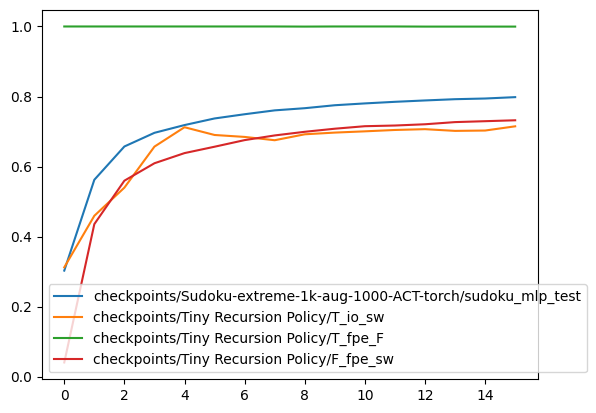

In [ ]:
for checkpoint in checkpoints:
    halt_fracs_np = np.array(halt_fracs[checkpoint]) / (num_batches * cfg.global_batch_size)
    plt.plot(halt_fracs_np, label=checkpoint)
    plt.legend()